In [1]:
# Import statement
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
# CV [0.3499997392102298, 0.3284038262336752, 0.33343077157089657, 0.33819979772871883, 0.3392584609200523]

In [6]:
def load_file_list(scoring_file):
    """
    Load filenames, their score and indices
    `scoring_file`: path to file of all scores
    return:
        - filenames -- list, control the order
        - dictionary -- {filename: index}
        - scores -- numpy array
    """
    
    file_name_list = []
    file_name_indices = {}
    scores = []
    
    with open(scoring_file, 'rt') as imgnames:
        lines = imgnames.readlines()
        for i in range(len(lines)):
            name, score = lines[i].strip().split(' ')
            file_name_indices[name] = i
            file_name_list.append(name)
            scores.append(float(score))
        scores = np.array(scores).reshape(-1, 1)
    return file_name_list, file_name_indices, scores

In [7]:
def load_images(image_folder, file_name_list):
    """
    Load images in image_folder to a numpy array, shape = [#files, width, height, chanel]
    Filnames are listed in `file_name_list`
    `image_folder` should be include all files in `file_name_list`, otherwise error will raise
    The results will include a numpy array, so this method should be used with small dataset
    Return
        - numpy array of images
    """
    img_data = []
    for i in range(len(file_name_list)):
        img_name = file_name_list[i]
        img = plt.imread(os.path.join(image_folder, img_name))
        img_data.append(img)
    
    return np.array(img_data)    

In [10]:
def filelist2indices(filelist, inddict):
    """
    Return indices of files from filelist in inddict
    This indices will be used to extract train/test from full loaded dataset
    `filelist`: file including line = [filename score]
    `inddict`: {filename: index} 
    """
    idx = []
    with open(filelist, 'rt') as file:
        for line in file.readlines():
            img_name = line.strip().split(' ')[0]
            idx.append(inddict[img_name])
    return np.array(idx)

In [8]:
# dataset
image_folder = './SCUT-FBP5500_v2/Images'
scoring_file = './SCUT-FBP5500_v2/train_test_files/All_labels.txt'

file_name_list, file_name_indices, scores = load_file_list(scoring_file)
images = load_images(image_folder, file_name_list)

In [11]:
# load train/test image indices
train_img_file = './SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt'
test_img_file = './SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/test.txt'
train_indices = filelist2indices(train_img_file, file_name_indices)
test_indices = filelist2indices(test_img_file, file_name_indices)

In [12]:
# resize images for test
images_R = []
for i in range(images.shape[0]):
    images_R.append(cv2.resize(images[i], (224,224)))
images_R = np.array(images_R)
# normalization
# 16GB memory will allocated because of float type
images_R = images_R/255.0

In [13]:
# define train, test

X_train = images_R[train_indices]
X_test = images_R[test_indices]

y_train = scores[train_indices]
y_test = scores[test_indices]

In [2]:
# Model import statement
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam

os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [27]:
# model creation
# similar to AlexNet architecture

model = Sequential()
# # 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), 
                 padding='valid', activation='relu', kernel_initializer='he_normal', name='CONV_1'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='MAX_POOL_1'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), 
                 padding='valid', activation='relu', kernel_initializer='he_normal', name='CONV_2'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='MAX_POOL_2'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), 
                 padding='valid', activation='relu', kernel_initializer='he_normal', name='CONV_3'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), 
                 padding='valid', activation='relu', kernel_initializer='he_normal', name='CONV_4'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                 padding='valid', activation='relu', kernel_initializer='he_normal', name='CONV_5'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='MAX_POOL_5'))

# ADD flatten
model.add(Flatten(name="FLATTEN"))
# ADD dense layer 512 hidden unit
model.add(Dense(units=32, activation='relu', name="Dense_1"))
# ADD dense layer
model.add(Dense( units=1, name="Dense_2", activation='relu'))

# optimizer
optimizer = Adam(lr=1e-4)
# Compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [28]:
# Summary model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 27, 27, 96)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 17, 17, 256)       2973952   
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 8, 8, 256)         0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 6, 6, 384)         885120    
_________________________________________________________________
CONV_4 (Conv2D)              (None, 4, 4, 384)         1327488   
_________________________________________________________________
CONV_5 (Conv2D)              (None, 2, 2, 256)         884992    
__________

In [29]:
his = model.fit(x=X_train, y=y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

Train on 3300 samples, validate on 2200 samples
Epoch 1/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.9280 - val_loss: 0.4464
Epoch 2/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.4024 - val_loss: 0.3583
Epoch 3/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.3440 - val_loss: 0.3020
Epoch 4/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.3085 - val_loss: 0.2858
Epoch 5/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.2784 - val_loss: 0.2667
Epoch 6/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.2398 - val_loss: 0.2500
Epoch 7/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.2197 - val_loss: 0.2337
Epoch 8/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.1976 - val_loss: 0.2259
Epoch 9/20
3300/3300 [==============================] - 7s 2ms/step - loss: 0.2011 - val_loss: 0.2487
Epoch 10/20
3300/3300 [===========

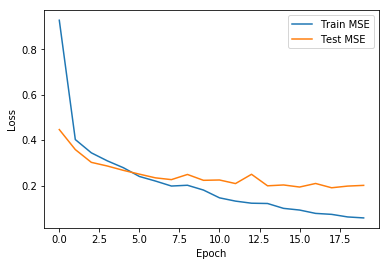

In [30]:
# plot train & test loss
%matplotlib inline

plt.plot(his.history['loss'], label='Train MSE')
plt.plot(his.history['val_loss'], label='Test MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [3]:
# 3300/3300 [==============================] - 5s 2ms/step - loss: 0.0631 - val_loss: 0.1881

In [31]:
model.save('beauty.h5')

In [32]:
# Save the model architecture
with open('beauty_model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [33]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('beauty_model_architecture.json', 'r') as f:
    model2 = model_from_json(f.read())

In [103]:
(model.predict(X_test)-y_test).argmax(axis=0)

array([1312])

In [30]:
model2.predict(X_test[0:2])

array([[2.9033563],
       [2.6761324]], dtype=float32)

In [32]:
y_test[0:2]

array([[2.8     ],
       [2.366667]])

In [104]:
test_indices[1312]

2948

In [105]:
scores[2948]

array([2.316667])

In [97]:
y_train[2861]

array([1.333333])

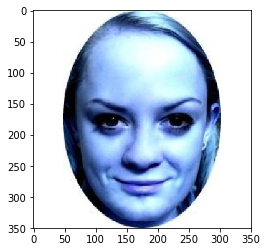

In [106]:
plt.imshow(images[2948])

In [99]:
model.predict(X_train)[2861]

array([1.456801], dtype=float32)

In [3]:
from keras.models import load_model
model2 = load_model('beauty.h5')

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen_test = ImageDataGenerator(rescale=1./255,data_format= "channels_last")
generator_test = \
    datagen_test.flow_from_directory(directory='./Selfie-dataset',
                                     class_mode=None,
                                     target_size=(224,224),
                                     batch_size=1024,
                                     shuffle=False
                                    )

Found 46836 images belonging to 1 classes.


In [29]:
import time
start = time.time()
pred = model2.predict_generator(generator_test)
print("predicted in {} seconds".format(int(time.time()-start)))

predicted in 87 seconds


In [37]:
pred.reshape(-1).argsort()[-5:][::-1]

array([41217, 15836, 30751, 27453, 40797])

In [38]:
pred.max()

6.2586684

In [55]:
top = np.array(generator_test.filenames)[[41217, 15836, 30751, 27453, 40797]]

In [58]:
def predict(model, file, folder=test_folder):
    img = cv2.imread(os.path.join(test_folder, file))
    img = cv2.resize(img, (224, 224))/255.0
    return model.predict(img.reshape(1,224,224,3))

In [67]:
start = time.time()
test_res = []
i = 1
for file in os.listdir(test_folder):
    if i%1000 == 0:
        print(i)
    test_res.append((file, predict(model2, file)[0][0]))
    i += 1
print("predicted in {} seconds".format(int(time.time()-start)))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
predicted in 378 seconds


In [73]:
aa = sorted(test_res, key=lambda x: x[1], reverse=True)[:6]

In [ ]:
print()

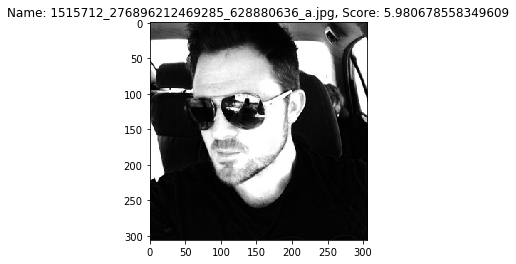

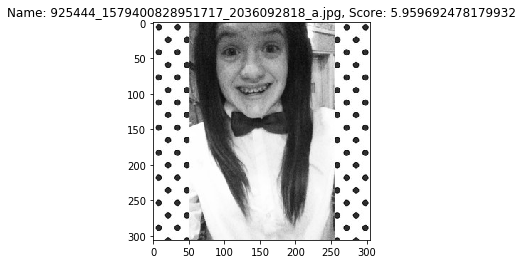

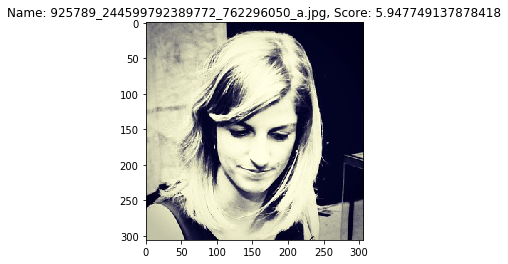

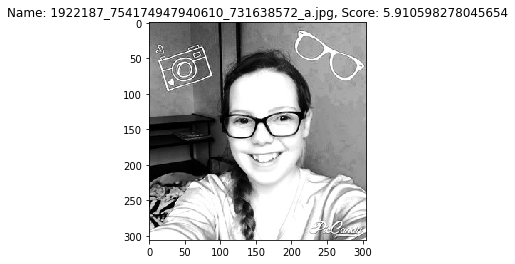

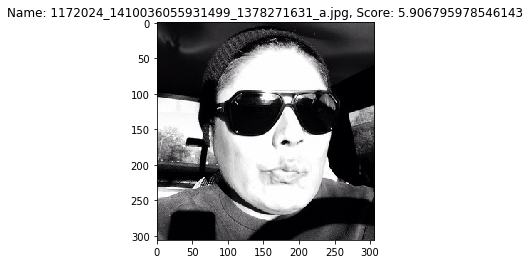

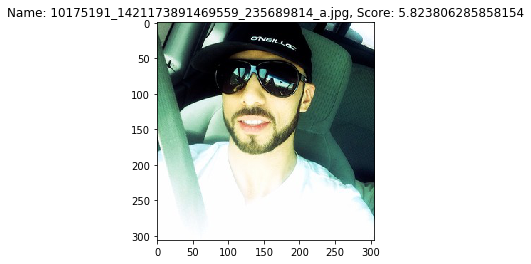

In [74]:
for img, score in aa:
    plt.figure()
    plt.title('Name: {}, Score: {}'.format(img, score))
    plt.imshow(plt.imread(os.path.join(test_folder, img)))  

In [ ]:
1515712_276896212469285_628880636_a.jpg
925444_1579400828951717_2036092818_a.jpg
925789_244599792389772_762296050_a.jpg
1922187_754174947940610_731638572_a.jpg
1172024_1410036055931499_1378271631_a.jpg

In [48]:
# # AlexNet
# #Instantiate an empty model
# model = Sequential()

# # 1st Convolutional Layer
# model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 2nd Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 3rd Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))

# # 4th Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))

# # 5th Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # Passing it to a Fully Connected layer
# model.add(Flatten())
# # 1st Fully Connected Layer
# model.add(Dense(4096, input_shape=(224*224*3,)))
# model.add(Activation('relu'))
# # Add Dropout to prevent overfitting
# model.add(Dropout(0.4))

# # 2nd Fully Connected Layer
# model.add(Dense(4096))
# model.add(Activation('relu'))
# # Add Dropout
# model.add(Dropout(0.4))

# # 3rd Fully Connected Layer
# model.add(Dense(1000))
# model.add(Activation('relu'))
# # Add Dropout
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(17))
# model.add(Activation('softmax'))

# model.summary()

In [45]:
# Create model 
model = Sequential()
# Add convolution 2D shape (5x5x32),padding same, stride=1)
model.add(
    Conv2D(filters=8, kernel_size=(7,7), padding='same', strides=(1, 1), 
           activation='relu', input_shape=(64,64,3), name='CONV_1',
           kernel_initializer='he_normal'
    )
)
# Add Max_pooling 2D kernel size(2,2),no padding, stride=2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name="MAX_POOL_1"))

# Add convolution 2D shape (3x3x64),padding same, stride=1 
model.add(
    Conv2D(filters=16, kernel_size=(5,5), padding='same', strides=(1, 1), 
           activation='relu', name='CONV_2', kernel_initializer='he_normal')
)

# Add Max_pooling 2D kernel size(2,2)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name="MAX_POOL_2"))

# ADD flatten
model.add(Flatten(name="FLATTEN"))

# ADD dense layer 512 hidden unit
model.add(Dense(units=32, activation='relu', name="Dense_1"))

# ADD dense layer
model.add(Dense( units=1, name="Dense_2", activation='relu'))

In [46]:
optimizer = Adam(lr=1e-4)

# Compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Summary model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 64, 64, 8)         1184      
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 32, 32, 8)         0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 32, 32, 16)        3216      
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 16, 16, 16)        0         
_________________________________________________________________
FLATTEN (Flatten)            (None, 4096)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                131104    
_________________________________________________________________
Dense_2 (Dense)              (None, 1)                 33        
Total para

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

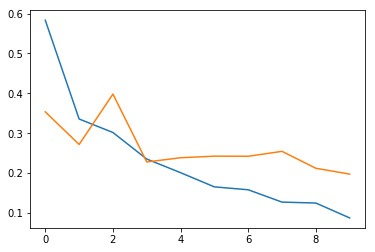

In [66]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])

In [52]:
his.history

{'val_loss': [0.23563349815932186,
  0.2547197730432857,
  0.24108685845678504,
  0.23499011305245487,
  0.23653514856641944,
  0.2841321045160294,
  0.24280780250375922,
  0.24011453894051638,
  0.24912441876801578,
  0.23402918972752312,
  0.23952600321986459,
  0.23981952911073512,
  0.2392437448826703,
  0.3049289065057581,
  0.23956340979446064,
  0.2587493127042597,
  0.2781894957477396,
  0.23578991917046635,
  0.24008889864791524,
  0.23904832769523968,
  0.2370227056199854,
  0.25037216072732754,
  0.24705462927168065,
  0.24134723246097564,
  0.2624387869509784,
  0.25276779158548873,
  0.2564462167566473,
  0.24338286139748314,
  0.2455205883221193,
  0.24509852263060483,
  0.2650341232798316,
  0.2578227385065772,
  0.2473161506652832,
  0.2491328996961767,
  0.24717713702808727,
  0.25203115571628915,
  0.251696855859323,
  0.2784774039008401,
  0.2516614041003314,
  0.254614026167176,
  0.2544169833985242,
  0.26313476752151144,
  0.2533536465059627,
  0.2543284352801063,

In [25]:
y_pred = model.predict(train)

In [36]:
((y_train-y_pred)**2).mean()

0.30780924177798863

In [32]:
((y_train-y_pred)**2).argmax(axis=0)

array([797])

In [33]:
y_train[797]

array([1.75])

In [34]:
y_pred[797]

array([3.651327], dtype=float32)